In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

In [3]:
# Tamaño imagen pixeles
desire_size = (64, 64)
# Canales rgb 
n_channels = 3
batch_size = 20

labels = list(map(lambda x: x.split("\\")[2], glob.glob("..\\resources/train\\*\\*")))
IDS = list(map(lambda x: x.split("\\")[3], glob.glob("..\\resources/train\\*\\*")))
le = preprocessing.LabelEncoder()
le.fit(list(set(labels)))
num_out = len(le.classes_)
pd.Series(labels).value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
cat                          164
cow                          164
dog                          164
horse                        164
Name: count, dtype: int64

Tiene 3 colores (196, 196, 3)


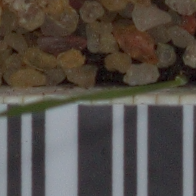

In [5]:
# Abre la imagen usando una ruta adecuada para Windows
img_color = Image.open(glob.glob(f"..\\resources/train\\*\\{IDS[0]}")[0])

# Imprime la cantidad de canales de color y la forma de la imagen
print(f"Tiene 3 colores {np.array(img_color).shape}")

# Muestra la imagen
img_color

Tiene 1 canal (196, 196)


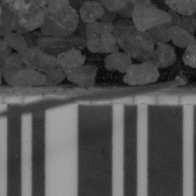

In [7]:
# Convierte la imagen a escala de grises
img_gris = img_color.convert('L')

# Imprime la cantidad de canales en la imagen convertida a escala de grises y su forma
# Esto debería mostrar que la imagen tiene un solo canal (escala de grises)
print(f"Tiene 1 canal {np.array(img_gris).shape}")

# Muestra la imagen en escala de grises
img_gris

In [9]:
def plot_1_images(d, label, ax=None):
    # Inicializa fig como None (esto se usa si no se proporciona un eje para graficar)
    fig = None

    # Si no se ha proporcionado un objeto de eje (`ax`), crea una nueva figura y un eje.
    if ax is None:
        fig, ax = plt.subplots(1, 1, constrained_layout=True)

    # Muestra la imagen `d` en el eje especificado
    ax.imshow(d)

    # Establece el título del gráfico utilizando el valor de `label`
    ax.set_title(label=label)

    # Retorna la figura y el eje, para que puedan ser utilizados o modificados externamente
    return fig, ax

# Data PreProcessing
Aqui simplemente se agrega un redimensión para luego guardar en un np.array y se entrenado y testeado en regresión y cnn 

In [11]:
# Inicializa una lista para almacenar tamaños de imágenes y etiquetas
ls_size = []

# Inicializa listas para las características (X) y etiquetas (y) del modelo
X = []
y = []

# Itera sobre cada archivo en las subcarpetas de "..\\resources/train\\*\\*"
for file in glob.glob("..\\resources/train\\*\\*"): 
    # Extrae la etiqueta (nombre de la subcarpeta) y el identificador de la imagen (nombre del archivo)
    label = file.split("\\")[2]
    id_img = file.split("\\")[3]

    # Abre la imagen y la convierte a escala de grises
    im = Image.open(file).convert('RGB')

    # Agrega el tamaño de la imagen, etiqueta y ID a `ls_size`
    ls_size.append([im.size[0], im.size[1], label, id_img])

    # Redimensiona la imagen a `desire_size` para estandarizar el tamaño
    img_resize = im.resize(desire_size)

    # Convierte la imagen redimensionada a un arreglo y la normaliza (dividiendo entre 255)
    img_array = np.array(img_resize) / 255.0
    X.append(img_array)

    # Agrega la etiqueta de la imagen a `y`
    y.append(label)

In [12]:
# Crear un arreglo de numpy de todas las imagenes
# X representa las imagenes unidimensionales
np.array(X).shape


(5406, 64, 64, 3)

(<Figure size 640x480 with 1 Axes>, <Axes: title={'center': 'Sugar beet'}>)

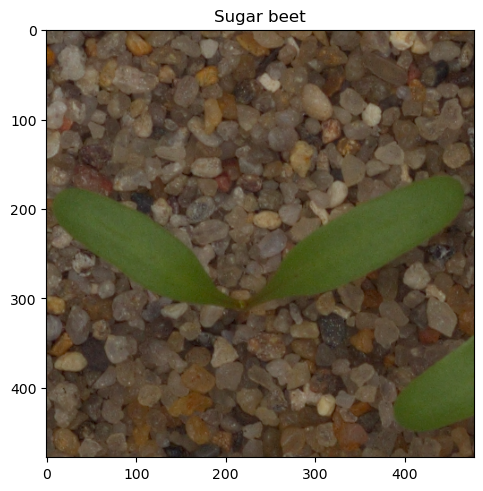

In [13]:
plot_1_images(im,label, ax=None)

(<Figure size 640x480 with 1 Axes>, <Axes: title={'center': 'Sugar beet'}>)

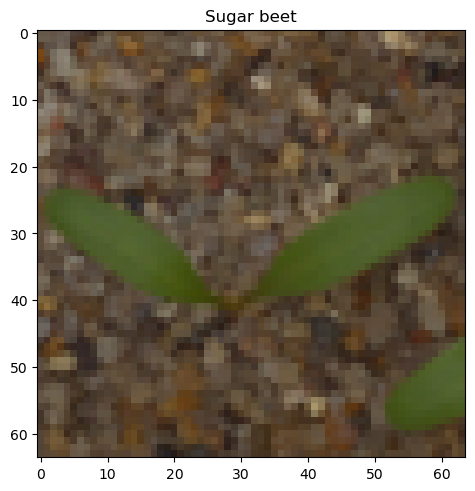

In [14]:
plot_1_images(img_resize,label, ax=None)

In [19]:
# Convierte las etiquetas en formato de codificación one-hot (matriz binaria) para que puedan ser usadas en redes neuronales
y_img = to_categorical(le.transform(y))

# Redimensiona X para que se ajuste al formato requerido por una red neuronal convolucional (CNN).
X_img = np.reshape(np.array(X), (-1, desire_size[0], desire_size[1], 3)) 

# Divide los datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X_img, y_img, test_size=0.2) 

# Regresion logistica
Aqui se define los parametros de la regresión logistica

In [20]:
# Redimensiona y normaliza las imágenes de entrenamiento y prueba
# Primero, las imágenes de X_train se aplanan a un arreglo unidimensional
# y luego se normalizan dividiendo por 255 (para llevar los valores de píxeles a un rango [0, 1])
X_train_lg = np.reshape(X_train, (-1, desire_size[0] * desire_size[1] * 3)) * 1/255
X_test_lg = np.reshape(X_test, (-1, desire_size[0] * desire_size[1] * 3)) * 1/255

# Convierte las etiquetas `y_train` y `y_test` en índices de clases (vectores one-hot a índices)
# `np.argmax` selecciona el índice del valor máximo en cada fila, que corresponde a la clase correcta
y_train_lg = np.argmax(y_train, axis=1)
y_test_lg = np.argmax(y_test, axis=1)

# Inicializa el clasificador de regresión logística con los siguientes parámetros:
# - random_state=0: asegura la reproducibilidad del modelo
# - solver='lbfgs': usa el algoritmo 'lbfgs' (un optimizador de gradiente de segunda orden)
# - max_iter=5000: establece el número máximo de iteraciones del algoritmo de optimización
# - penalty='l2': utiliza regularización L2 (penalización en los pesos)
# - C=0.1: establece el valor de regularización (C es el inverso de la fuerza de regularización)
clf = LogisticRegression(random_state=0,
                         solver='lbfgs', max_iter=5000,
                         penalty='l2', C=0.1)

# Entrena el clasificador con las características de entrenamiento (X_train_lg) y las etiquetas (y_train_lg)
clf.fit(X_train_lg, y_train_lg)

LogisticRegression(C=0.1, max_iter=5000, random_state=0)

<Axes: >

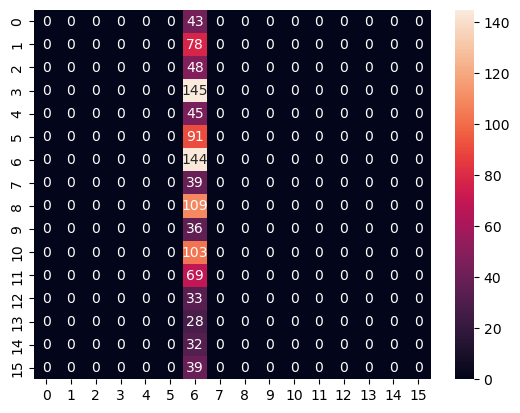

In [21]:
cm = confusion_matrix(y_test_lg, clf.predict(X_test_lg))
sns.heatmap(cm, annot=True, fmt='g')

In [22]:
accuracy_score(y_test_lg, clf.predict(X_test_lg))

0.133086876155268

In [27]:
# Lista para almacenar las imágenes procesadas en el conjunto de prueba (test)
X_oob = []

# Lista para almacenar los nombres o identificadores de los archivos de imagen en el conjunto de prueba
file_oob = []

# Itera sobre cada archivo de imagen en el directorio "data/test"
for file in glob.glob("..\\resources/test\\*"):
    # Abre la imagen en escala de grises ('L' convierte la imagen a 1 canal)
    im = Image.open(file).convert('RGB')
    
    # Cambia el tamaño de la imagen a las dimensiones especificadas en 'desire_size'
    img_resize = im.resize(desire_size)
    
    # Convierte la imagen redimensionada en un arreglo numpy 1D (plano) y lo añade a la lista X_oob
    X_oob.append(np.array(img_resize).flatten())
    
    # Extrae el nombre o identificador del archivo desde la ruta y lo añade a la lista file_oob
    # Se asume que el identificador está en la tercera posición de la ruta (ajusta si es necesario)
    file_oob.append(file.split("\\")[2])

In [28]:
X_sub_lg = np.reshape(X_oob, (-1, desire_size[0]*desire_size[1]))*1/255
df_oob = pd.DataFrame(data= zip(file_oob, le.inverse_transform(clf.predict(X_test_lg))),
                        columns=["file","label"])

In [29]:
df_oob.to_csv("regresion.csv", index=False)

In [30]:
# Refrescar memoria
X_train_lg = X_test_lg = y_train_lg = y_test_lg = None

# CNN
En esta parte se definen las capas del cnn

In [36]:
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=8, input_shape=(desire_size[0],desire_size[1],3),
                 kernel_size=(4,4),padding='same', activation='relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(200, activation='relu'))

# Add Dropout
model.add(Dropout(0.1))

# 2nd Fully Connected Layer
model.add(Dense(100, activation='relu'))

# Add Dropout
model.add(Dropout(0.1))

# 3rd Fully Connected Layer
model.add(Dense(50, activation='relu'))

# Add Dropout
model.add(Dropout(0.1))

# Output Layer
model.add(Dense(num_out, activation='softmax'))

model.summary()

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=["accuracy"])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 8)      │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 31, 31, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 15, 15, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │     1,638,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,709,358 (6.52 MB)

 Trainable params: 1,709,358 (6.52 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [40]:
model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=60,batch_size=64)

Epoch 1/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.1072 - loss: 2.7196 - val_accuracy: 0.1654 - val_loss: 2.3467
Epoch 2/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.1434 - loss: 2.4248 - val_accuracy: 0.2079 - val_loss: 2.2656
Epoch 3/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.1580 - loss: 2.3476 - val_accuracy: 0.1701 - val_loss: 2.2596
Epoch 4/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.1814 - loss: 2.2853 - val_accuracy: 0.2763 - val_loss: 2.1137
Epoch 5/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.2544 - loss: 2.0981 - val_accuracy: 0.4381 - val_loss: 1.6162
Epoch 6/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.3998 - loss: 1.6771 - val_accuracy: 0.5314 - val_loss: 1.3859
Epoch 7/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.4761 - loss: 1.4288 - val_accuracy: 0.5823 - val_loss: 1.1848
Epoch 8/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.5491 - loss: 1.2936 - val_accu

In [47]:
X_oob_img = np.reshape(np.array(X_oob), (-1, desire_size[0], desire_size[1], 3))
y_hat = le.inverse_transform(np.argmax(model.predict(X_oob_img), axis=1))
df_oob = pd.DataFrame(data= zip(file_oob, y_hat),
                        columns=["file","label"])
df_oob.to_csv("cnn.csv", index=False)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
